In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import timedelta, datetime
import wrangle
import warnings
import evaluate
warnings.filterwarnings('ignore')

# The Data

The original dataset is provided by the State of Texas Open Data Portal. Every establishment licensed to sell alcohol by the Texas Alcoholic Beverage Commision must publicly report their mixed beverage gross reciepts monthly by law. This file contains a list of taxpayers required to report mixed beverage gross receipts tax reports under Tax Code Chapter 183, Subchapter B. The list provides taxpayer names, amounts reported, and other public information. The Data is managed by the Texas Comptroller of Public Accounts, it originally contained around 3 millon rows and 24 columns.

## The Plan 
1. **Data preprocessing**: Clean and preprocess the data to ensure it is suitable for creating a predictive model.  This involved handling missing values, converting categorical variables from numerical format, and converting obligation_end_date to date time.

2. **Feature engineering**: Create new features that might have a relationship with a bar's beer ratio growth. This may include lagged features to account for previous months' beer ratios, aggregated features like rolling averages, and interaction features that capture the relationship between different columns.

3. **Exploratory data analysis (EDA)**: Perform an EDA to understand the relationships between different features and the target variable (beer ratio growth). This will help identify potential predictors and understand the trends and patterns in the data.

4. **Model training and validation**: Split the data into training and validation sets. Train the selected model(s) on the training set and evaluate their performance on the validation set using appropriate metrics such as Root Mean Squared Error (RMSE). Fine-tune the model parameters to improve the model's performance.

5. **Model evaluation**: Use cross-validation techniques to get a more accurate estimate of the model's performance on unseen data. This will help identify potential overfitting or underfitting issues.

6. **Sales strategy**: Based on the predictions from the model, identify the bars with the highest potential for beer ratio growth. Prioritize these bars in the sales strategy, focusing on areas with the highest concentration of high-potential bars. Develop a targeted marketing plan to appeal to these bars, emphasizing the growing demand for beer and the benefits of partnering with your distribution company.

7. **Continuous improvement**: Regularly update the model with new data to ensure it stays relevant and accurate. Monitor the model's performance and adjust the sales strategy as needed. Explore additional data sources that might help improve the model's predictive power, such as external factors like local events, economic indicators, or demographic data. A brand could also examine the list and remove existing customers from the sales strategy. Additional data collected about the bars and GIS information my improve the model and understanding of drivers.

1. **Data preprocessing**: Clean and preprocess the data to ensure it is suitable for creating a predictive model. This involved handling missing values, converting categorical variables from numerical format, and converting obligation_end_date to date time.
- For this project, I scoped the data down to just include the establishments in San Antonio, resulting in about 200K rows.
    - I drop unimportant and redundant data columns from the data, like taxpayer information and license information.
    - I also created 7 new columns from the data provided.
    - Removed 60% of low BR sales priority to balance date going into modeling
- After cleaning data and removing establishments that did not report any beer sales, about 90K rows were left.

# Data Dictionary


| Column Name           | Data Type       | Description                                                                                                 |
|-----------------------|-----------------|-------------------------------------------------------------------------------------------------------------|
| location_name         | object          | The name of the bars                                                                                        |
| location_zip          | object          | The zip code of the bar location                                                                            |
| obligation_end_date   | datetime64[ns]  | The last day of the reporting month                                                                         |
| liquor_receipts_in_usd| float64         | The amount of tax the bar paid for liquor                                                                   |
| wine_receipts_in_usd  | float64         | The amount of tax the bar paid for wine                                                                     |
| beer_receipts_in_usd  | float64         | The amount of tax the bar paid for beer                                                                     |
| total_receipts_in_usd | float64         | The total amount of tax the bar paid for beer, wine, and liquor                                            |
| beer_ratio            | float64         | The percentage of beer tax to total tax                                                                     |
| br_sales_priority     | object          | A sales priority created from beer ratio: urgent = beer_ratio > 90, high = 75 < beer_ratio <= 90, mid = 50 < beer_ratio <= 75, low = beer_ratio < 50 |
| zip_sales_priority    | object          | A sales priority created from average beer_ratio of location_zip: locations in zip codes with urgent = average_beer_ratio > 55, high = 50 < average_beer_ratio <= 55, mid = 40 < average_beer_ratio <= 50, low = average_beer_ratio < 40 |
| year                  | int64           | The year extracted from the 'obligation_end_date' column                                                   |
| month                 | int64           | The month extracted from the 'obligation_end_date' column                                                  |
| avg_yearly_diff       | float64         | The average difference in beer_ratio per location for each year                                            |
| avg_monthly_diff      | float64         | The average difference in beer_ratio per location for each month                                           

In [3]:
#load Data Set from CSV
df = wrangle.get_sa_mixed_bev()
#format zip and obligation end date
df.location_zip = df.location_zip.astype('O')
df.obligation_end_date = pd.to_datetime(df.obligation_end_date)

In [4]:
#show shape
df.shape

(86449, 14)

In [4]:
#dtypes
df.dtypes

location_name                     object
location_zip                      object
obligation_end_date       datetime64[ns]
liquor_receipts_in_usd           float64
wine_receipts_in_usd             float64
beer_receipts_in_usd             float64
total_receipts_in_usd            float64
beer_ratio                       float64
br_sales_priority                 object
zip_sales_priority                object
year                               int64
month                              int64
avg_yearly_diff                  float64
avg_monthly_diff                 float64
dtype: object

2. **Feature engineering**: Create new features that might have a relationship with a bar's beer ratio growth. This includes lagged features to account for previous months' beer ratios, aggregated features like rolling averages, and interaction features that capture the relationship between different columns.

In [117]:
# Create lagged features for beer_ratio (1-month lag, 2-months lag, and 3-months lag)
df['beer_ratio_lag1'] = df.groupby('location_zip')['beer_ratio'].shift(1)
df['beer_ratio_lag2'] = df.groupby('location_zip')['beer_ratio'].shift(2)
df['beer_ratio_lag3'] = df.groupby('location_zip')['beer_ratio'].shift(3)

# Calculate the rolling averages for beer_ratio (3-month and 6-month windows)
df['beer_ratio_rolling3'] = df.groupby('location_zip')['beer_ratio'].rolling(window=3).mean().reset_index(0, drop=True)
df['beer_ratio_rolling6'] = df.groupby('location_zip')['beer_ratio'].rolling(window=6).mean().reset_index(0, drop=True)

# Create interaction features between beer_receipts_in_usd and liquor_receipts_in_usd, wine_receipts_in_usd
df['beer_liquor_interaction'] = df['beer_receipts_in_usd'] * df['liquor_receipts_in_usd']
df['beer_wine_interaction'] = df['beer_receipts_in_usd'] * df['wine_receipts_in_usd']

# Calculate beer ratio growth (current month beer ratio - previous month beer ratio)
df['beer_ratio_growth'] = df['beer_ratio'] - df['beer_ratio_lag1']

3. **Exploratory data analysis (EDA)**: Perform an EDA to understand the relationships between different features and the target variable (beer ratio growth). This will help identify potential predictors and understand the trends and patterns in the data.

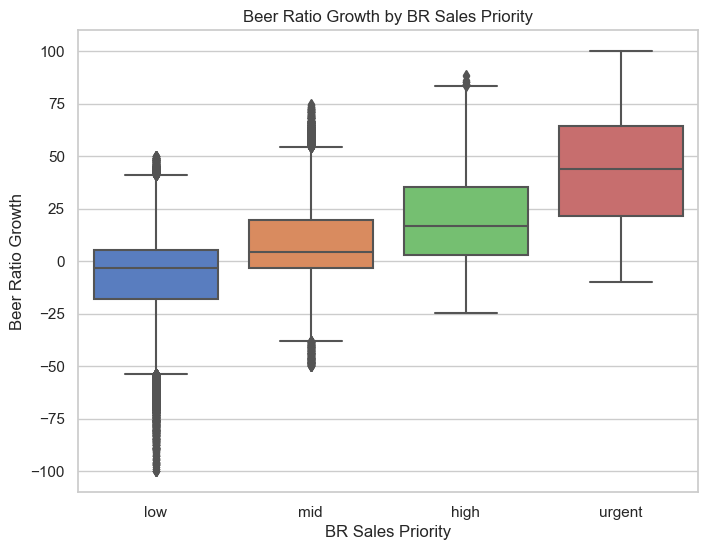

In [118]:
# Box plot to compare beer_ratio_growth across different br_sales_priority categories
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='br_sales_priority', y='beer_ratio_growth', order=['low', 'mid', 'high', 'urgent'])
plt.xlabel('BR Sales Priority')
plt.ylabel('Beer Ratio Growth')
plt.title('Beer Ratio Growth by BR Sales Priority')
plt.show()

from our box chart we can see that our br_sales_priority catagories are correctly capturing the bulk of beer ratio growth data, but there is still alot of over lap that can be accounted for by actually predicting beer growth ratio or binning the br_sales_priority by growth rather than direct ratio.

In [119]:
# Define the function to categorize the sales_priority
def categorize_priority(beer_ratio):
    if beer_ratio > 75:
        return 'urgent'
    elif 50 < beer_ratio <= 75:
        return 'high'
    elif 25 < beer_ratio <= 50:
        return 'mid'
    else:
        return 'low'

# Apply the categorize_priority function to the 'beer_ratio' column and create the new 'br_sales_priority' column
df['br_growth_sales_priority'] = df['beer_ratio_growth'].apply(categorize_priority)

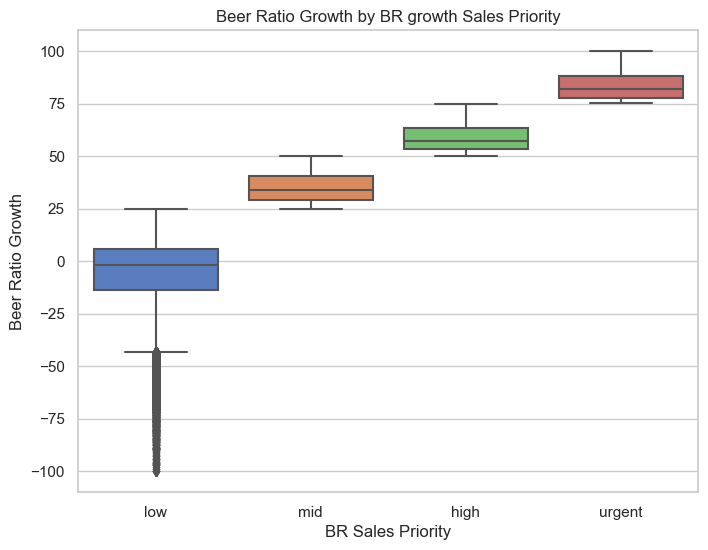

In [120]:
# Box plot to compare beer_ratio_growth across different br_sales_priority categories
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='br_growth_sales_priority', y='beer_ratio_growth', order=['low', 'mid', 'high', 'urgent'])
plt.xlabel('BR Sales Priority')
plt.ylabel('Beer Ratio Growth')
plt.title('Beer Ratio Growth by BR growth Sales Priority')
plt.show()

Here we can see by using these BR growth bins, we capturing data was previously in the mid high catagory now captured in the urgent bin and clear delinations between our sales groups.

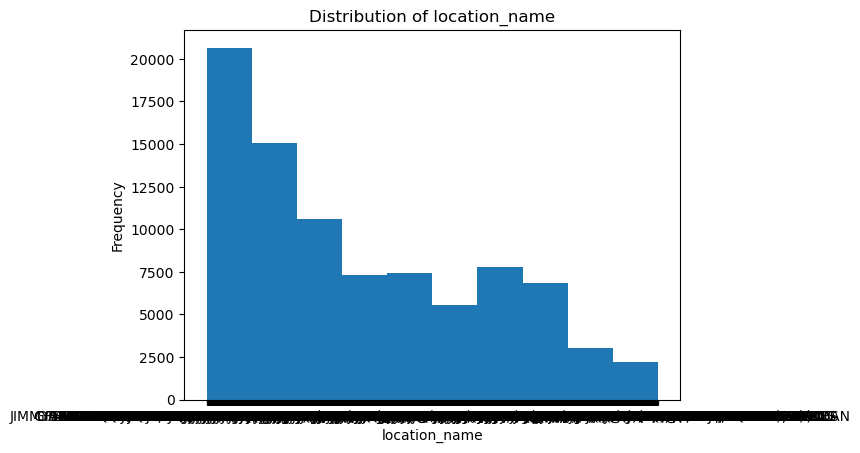

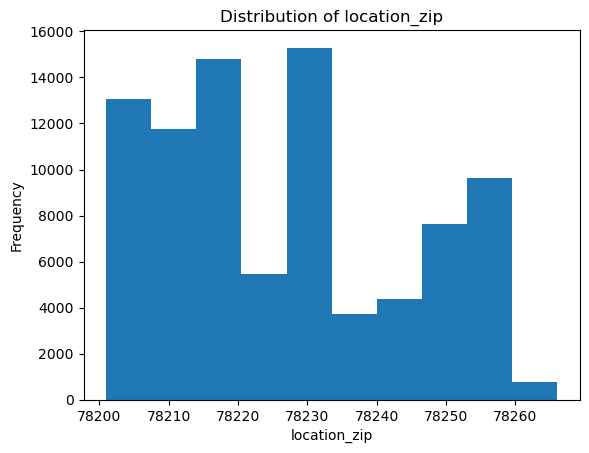

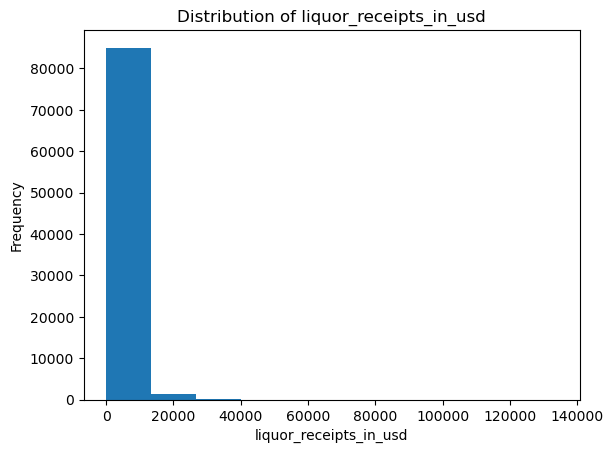

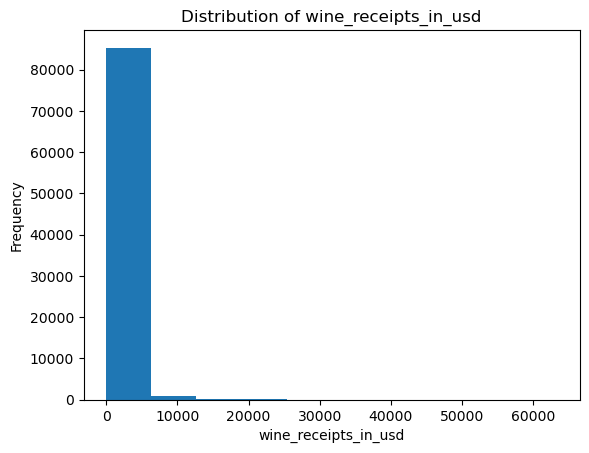

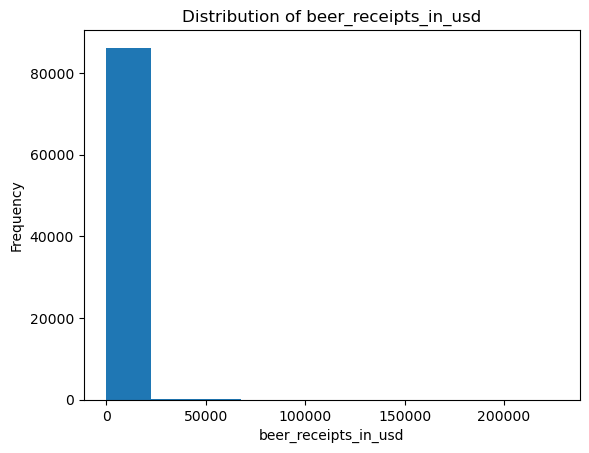

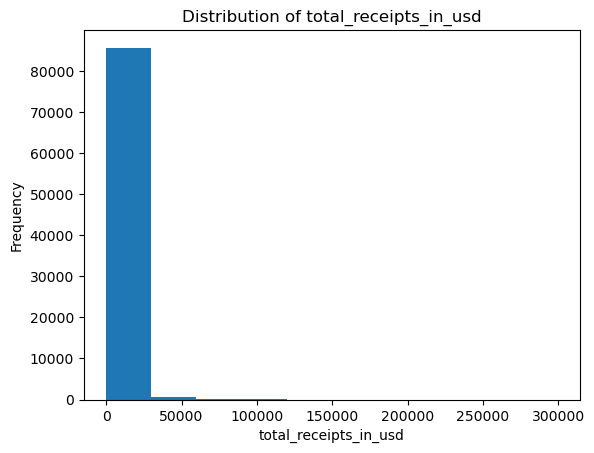

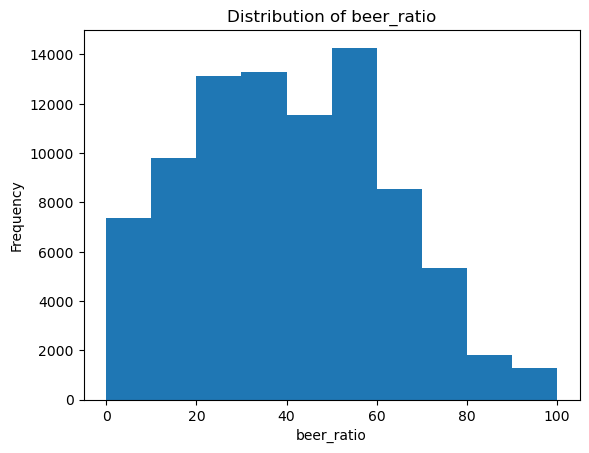

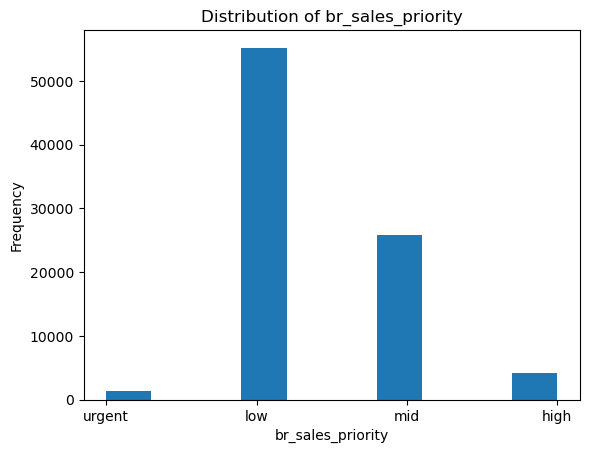

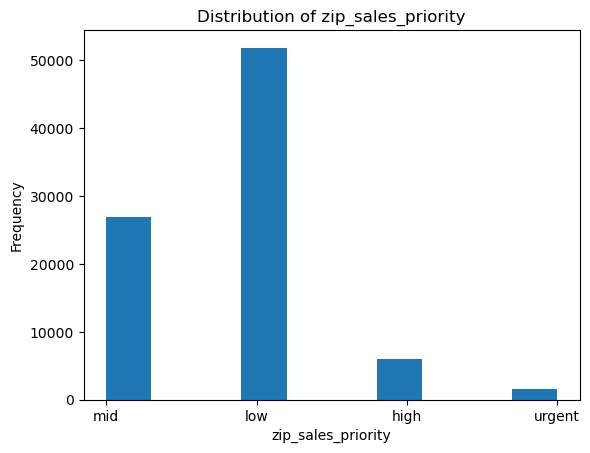

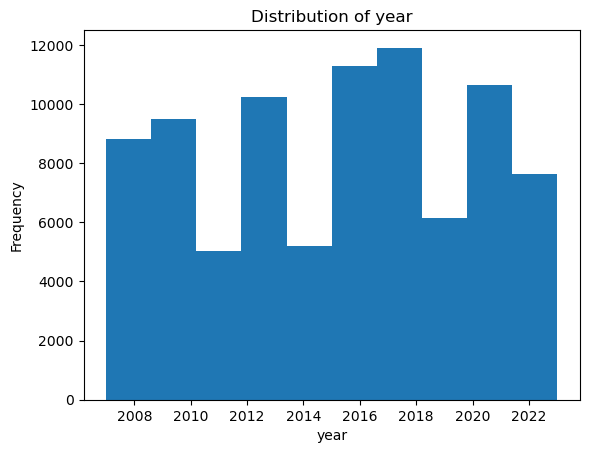

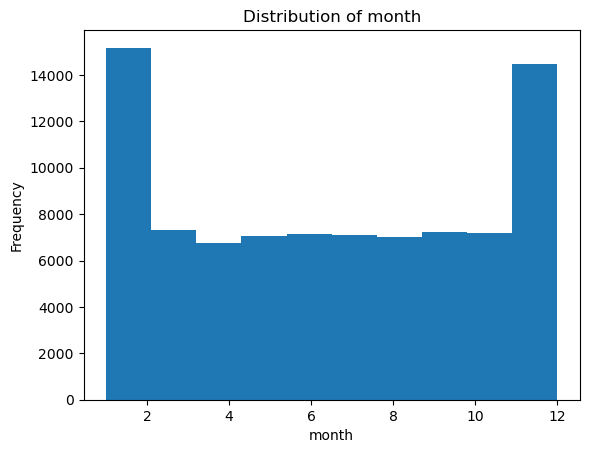

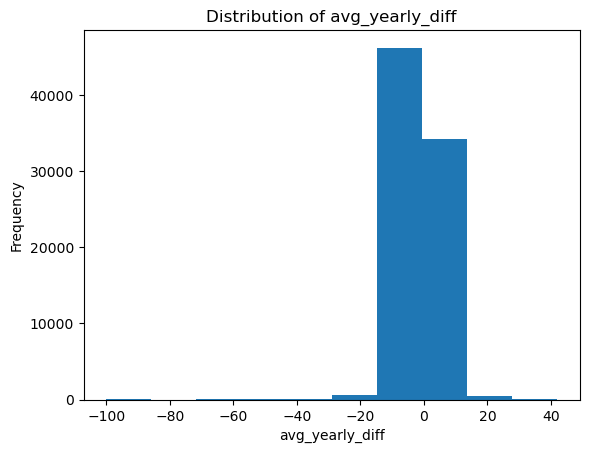

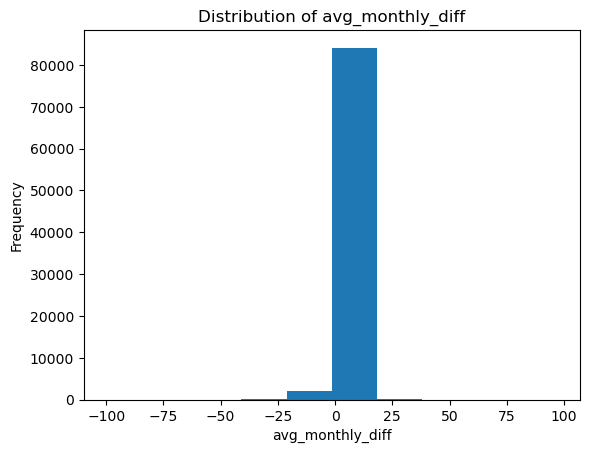

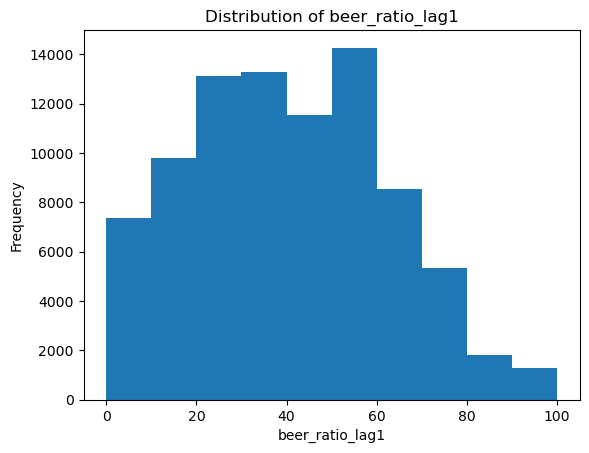

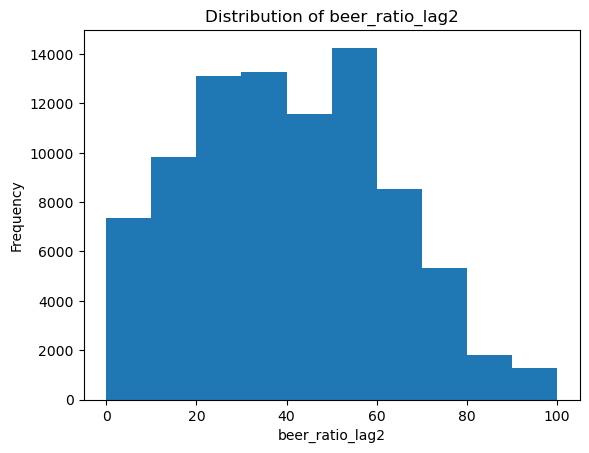

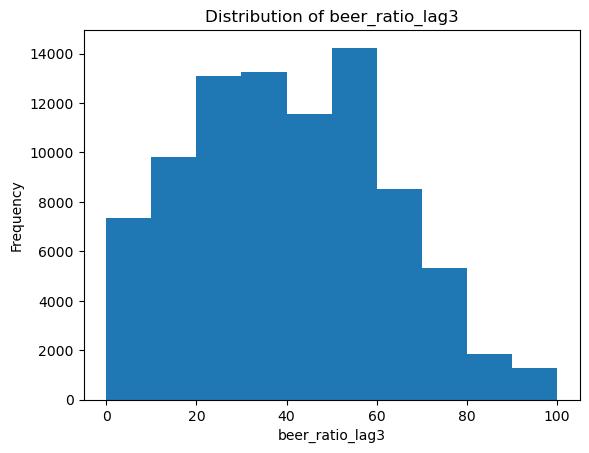

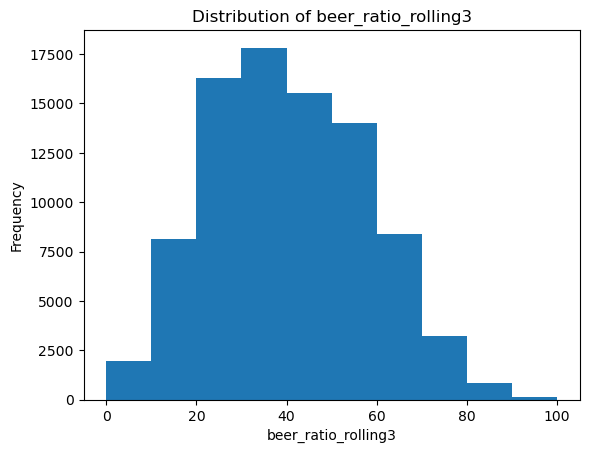

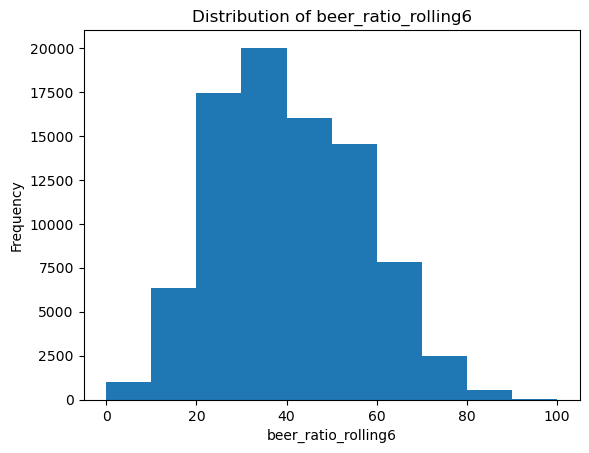

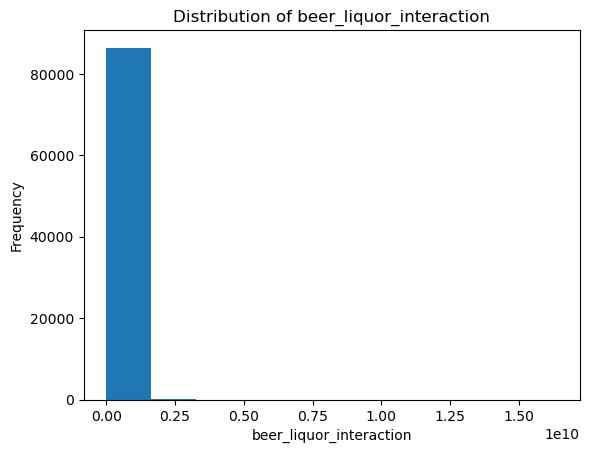

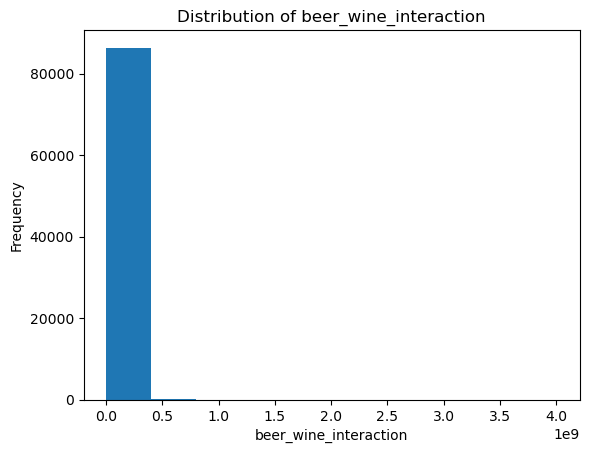

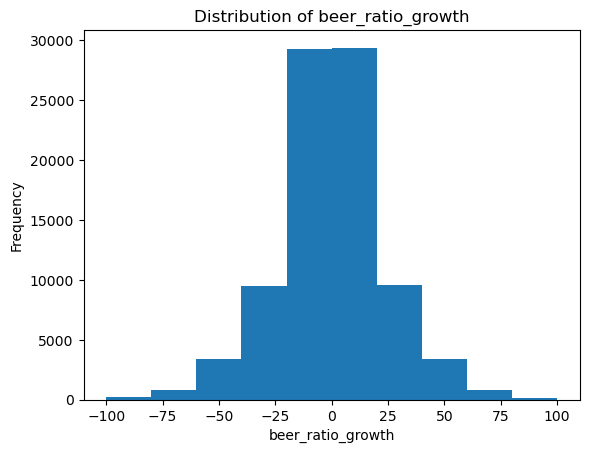

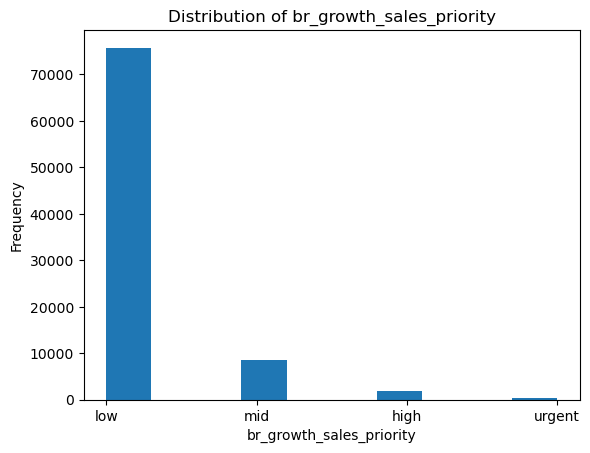

In [19]:
for column in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df[column]):
        evaluate.show_distribution(df, column)

In [15]:
#just numeric features
numeric_features = ['beer_ratio', 'avg_monthly_diff','beer_ratio_lag1', 'beer_ratio_lag2', 'beer_ratio_lag3',
                    'beer_ratio_rolling3', 'beer_ratio_rolling6', 'beer_liquor_interaction',
                    'beer_wine_interaction', 'beer_ratio_growth']

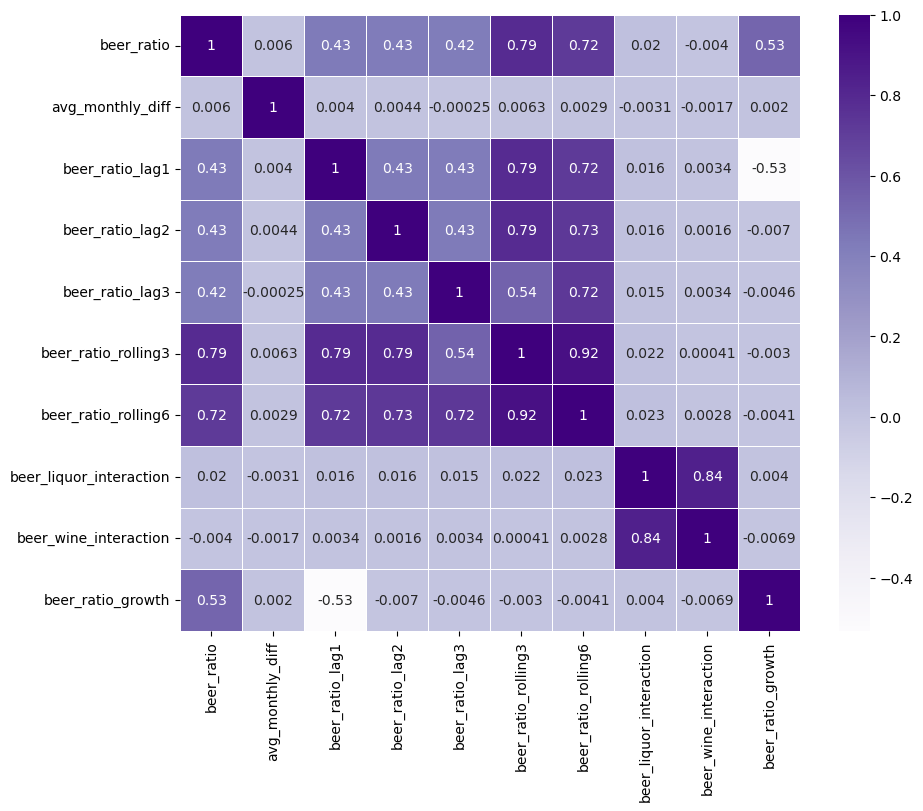

In [16]:
# Correlation heatmap to see how features are correlated with beer_ratio_growth
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Purples", linewidths=0.5)
plt.show()

From this correlation matrix we can see that our features that are not time dependent have the lowest correlation values and as our lag increases, our correlation value goes down when predicting beer ratio growth. We could either use a Time series or a regression model using the time related features.

# TSA Exploration

In [15]:
df.columns

Index(['location_name', 'location_zip', 'obligation_end_date',
       'liquor_receipts_in_usd', 'wine_receipts_in_usd',
       'beer_receipts_in_usd', 'total_receipts_in_usd', 'beer_ratio',
       'br_sales_priority', 'zip_sales_priority', 'year', 'month',
       'avg_yearly_diff', 'avg_monthly_diff', 'beer_ratio_lag1',
       'beer_ratio_lag2', 'beer_ratio_lag3', 'beer_ratio_rolling3',
       'beer_ratio_rolling6', 'beer_liquor_interaction',
       'beer_wine_interaction', 'beer_ratio_growth',
       'br_growth_sales_priority'],
      dtype='object')

In [121]:
df = df.drop(columns=['location_zip',
       'liquor_receipts_in_usd', 'wine_receipts_in_usd',
       'beer_receipts_in_usd', 'total_receipts_in_usd',
       'br_sales_priority', 'zip_sales_priority', 
       'avg_yearly_diff', 'avg_monthly_diff',
       'beer_ratio_lag2', 'beer_ratio_lag3',
       'beer_ratio_rolling6', 'beer_liquor_interaction',
       'beer_wine_interaction'])

In [25]:
df

,location_name,beer_ratio,year,month,beer_ratio_lag1,beer_ratio_rolling3,beer_ratio_growth,br_growth_sales_priority
obligation_end_date,,,,,,,,
2007-01-31,CHILI'S GRILL & BAR,44.92,2007,1,53.56,41.75,-8.64,low
2007-01-31,ANNE MARIE'S AT DEVONSHIRE PLACE,23.71,2007,1,35.81,53.17,-12.11,low
2007-01-31,THE SPEEDWAY SPORTS BAR,59.56,2007,1,13.92,31.89,45.63,mid
2007-01-31,ALDINOS AT THE VINEYARD,3.69,2007,1,16.76,7.52,-13.08,low
2007-01-31,MAIN STREET BAR AND CO,58.10,2007,1,36.80,43.43,21.30,low
...,...,...,...,...,...,...,...,...
2023-03-31,EL CHOLULAS MEXICAN GRILL,32.51,2023,3,46.64,38.77,-14.13,low
2023-03-31,DICK'S LAST RESORT,35.43,2023,3,24.42,21.24,11.01,low
2023-03-31,STONE WERKS BIG ROCK GRILLE,25.28,2023,3,62.27,37.05,-36.99,low


In [103]:
#Set obligation end date as index 
df = df.set_index('obligation_end_date').sort_index()

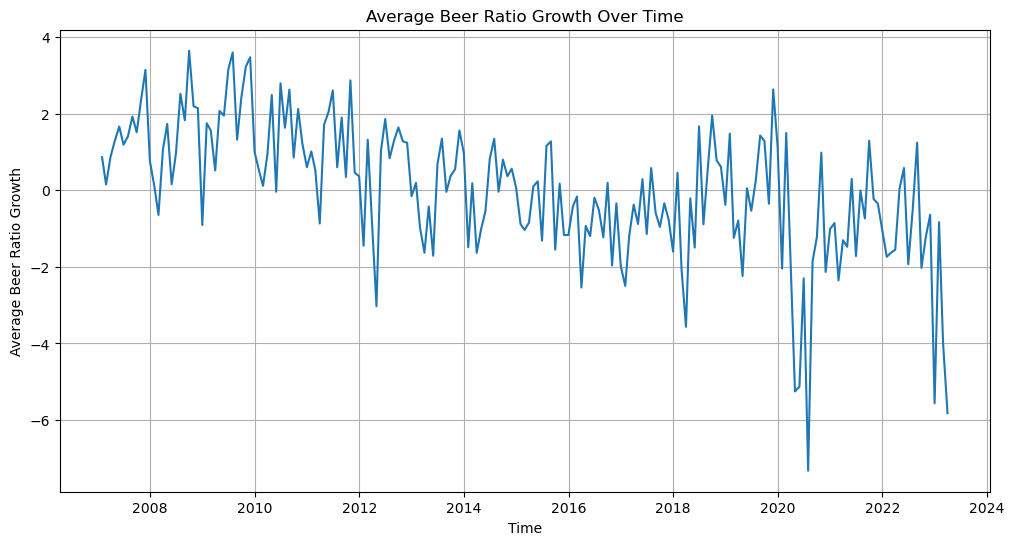

In [55]:
# Resample the data to calculate the monthly average of beer_ratio_growth
monthly_average = df['beer_ratio_growth'].resample('M').mean()

# Plot the monthly average beer_ratio_growth
plt.figure(figsize=(12, 6))
plt.plot(monthly_average.index, monthly_average.values)
plt.xlabel('Time')
plt.ylabel('Average Beer Ratio Growth')
plt.title('Average Beer Ratio Growth Over Time')
plt.grid(True)
plt.show()

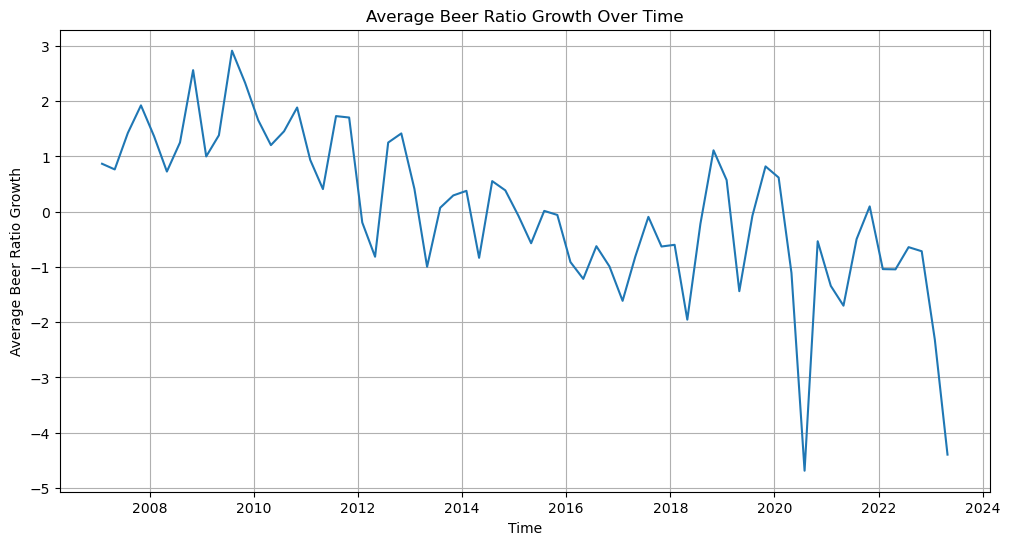

In [20]:
# Resample the data to calculate the monthly average of beer_ratio_growth
quarterly_average = df['beer_ratio_growth'].resample('3M').mean()

# Plot the monthly average beer_ratio_growth
plt.figure(figsize=(12, 6))
plt.plot(quarterly_average.index, quarterly_average.values)
plt.xlabel('Time')
plt.ylabel('Average Beer Ratio Growth')
plt.title('Average Beer Ratio Growth Over Time')
plt.grid(True)
plt.show()

because of the huge spikes here we sould drop the data from 2020 and 2023 to improve the model, we'll train on 2018 and 2019 and test on 2022.

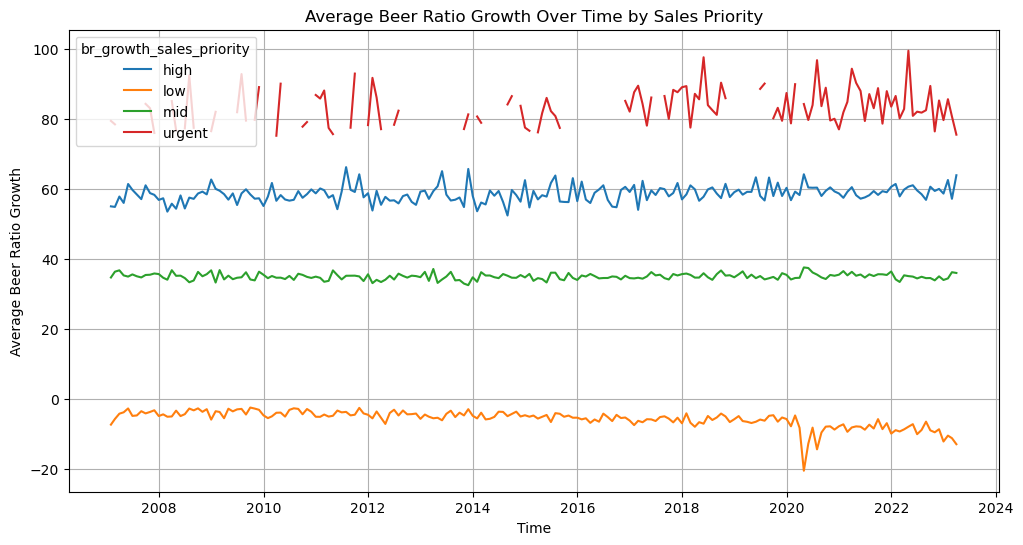

In [56]:
# Group the data by 'br_growth_sales_priority'
grouped = df.groupby('br_growth_sales_priority')

# Resample the data to calculate the monthly average of beer_ratio_growth for each group
monthly_averages = grouped['beer_ratio_growth'].resample('M').mean()

# Plot the monthly average beer_ratio_growth for each group
plt.figure(figsize=(12, 6))

for group_name, group_data in monthly_averages.groupby(level=0):
    plt.plot(group_data.index.get_level_values(1), group_data.values, label=group_name)

plt.xlabel('Time')
plt.ylabel('Average Beer Ratio Growth')
plt.title('Average Beer Ratio Growth Over Time by Sales Priority')
plt.legend(title='br_growth_sales_priority')
plt.grid(True)
plt.show()

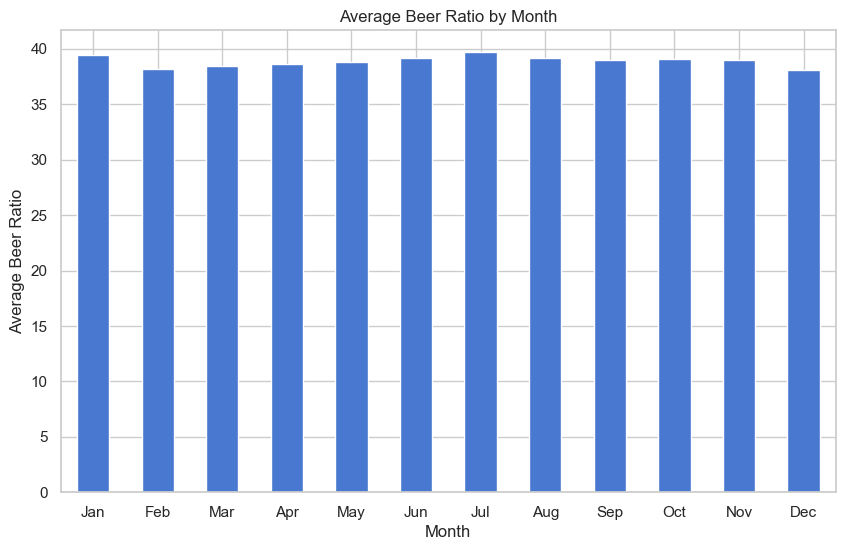

In [100]:
# Calculate the average beer ratio by month
avg_beer_ratio_by_month = df.groupby('month')['beer_ratio'].mean()

# Create a bar plot to visualize the average beer ratio by month
plt.figure(figsize=(10, 6))
avg_beer_ratio_by_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Beer Ratio')
plt.title('Average Beer Ratio by Month')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

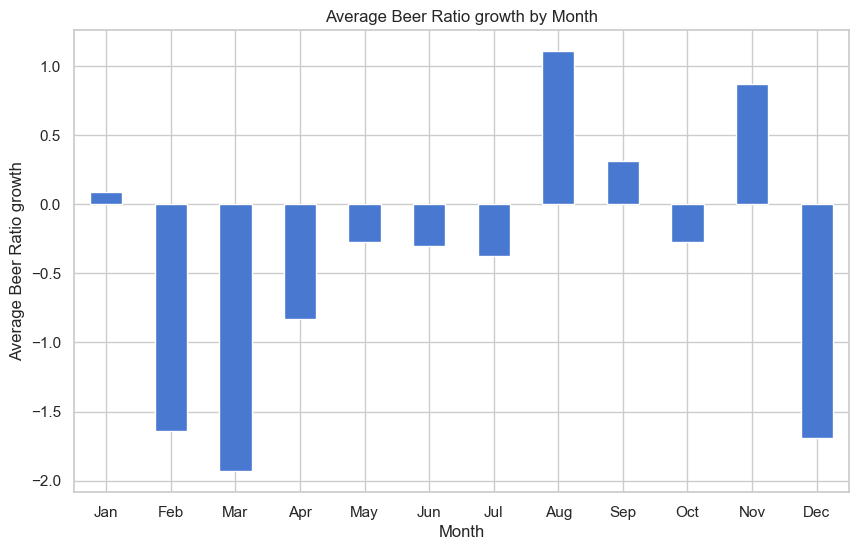

In [101]:
# Calculate the average beer ratio growth by month
avg_beer_ratio_by_month = df.groupby('month')['beer_ratio_growth'].mean()

# Create a bar plot to visualize the average beer ratio by month
plt.figure(figsize=(10, 6))
avg_beer_ratio_by_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Beer Ratio growth')
plt.title('Average Beer Ratio growth by Month')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

# Exploration summary
- 2019 is missing a good bit of urgent sales catagory
- average beer ratio by month is pretty steady
- average growth is mostly negative, people are generally buying less beer.
- January and December make up a significant portion of the data set
- This project is a good canidate for a Forcasting but for the sake of time I'm going to use a regression

# modeling

In [105]:
df = df.reset_index()

In [123]:
df = df[df.year.isin([2018,2019,2021,2022])]
#df length is 18560

In [125]:
df.location_name.nunique()

1441

In [126]:
df.dtypes

location_name                       object
obligation_end_date         datetime64[ns]
beer_ratio                         float64
year                                 int64
month                                int64
beer_ratio_lag1                    float64
beer_ratio_rolling3                float64
beer_ratio_growth                  float64
br_growth_sales_priority            object
dtype: object

In [124]:
df.year.value_counts()

2022    6365
2019    6149
2018    6046
2021    5883
Name: year, dtype: int64

4. **Model training and validation**: Split the data into training and validation sets. Train the selected model(s) on the training set and evaluate their performance on the validation set using appropriate metrics such as Root Mean Squared Error (RMSE). Fine-tune the model parameters to improve the model's performance.

In [153]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Preprocess and split the data into train, validation, and test sets
features = ['year', 'month', 'beer_ratio_lag1', 'beer_ratio_rolling3']
target = 'beer_ratio_growth'

X = df[features].dropna()
y = df.loc[X.index, target]

# Filter the data based on specific years
X_train = X[(X['year'] == 2018) | (X['year'] == 2019)]
y_train = y[X_train.index]
X_val = X[X['year'] == 2021]
y_val = y[X_val.index]
X_test = X[X['year'] == 2022]
y_test = y[X_test.index]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

# Train and evaluate the models
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    train_preds = model.predict(X_train_scaled)
    val_preds = model.predict(X_val_scaled)
    test_preds = model.predict(X_test_scaled)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    
    results.append([name, train_rmse, val_rmse, test_rmse])

# Compute the baseline RMSE using the mean beer_ratio_growth
baseline_rmse_train = np.sqrt(mean_squared_error(y_train, [y_train.mean()] * len(y_train)))
baseline_rmse_val = np.sqrt(mean_squared_error(y_val, [y_val.mean()] * len(y_val)))
baseline_rmse_test = np.sqrt(mean_squared_error(y_test, [y_test.mean()] * len(y_test)))

# Add the baseline RMSE to the results
results.append(['Baseline', baseline_rmse_train, baseline_rmse_val, baseline_rmse_test])

# Create a dataframe of predictions for each model
predictions_df = pd.DataFrame({
    'location_name': df.loc[X_test.index, 'location_name'],
    'beer_ratio': df.loc[X_test.index, 'beer_ratio'],
    'beer_ratio_growth': df.loc[X_test.index, 'beer_ratio_growth'],
    'obligation_end_date': df.loc[X_test.index, 'obligation_end_date'],
    'year': X_test['year'],
    'month': X_test['month'],
    'Baseline': df.loc[X_test.index, 'beer_ratio_growth'].mean(),
    'Linear Regression': models['Linear Regression'].predict(X_test_scaled),
    'Ridge Regression': models['Ridge Regression'].predict(X_test_scaled),
    'Lasso Regression': models['Lasso Regression'].predict(X_test_scaled)
})

# Create a table showing the performance of each model on train, validation, and test sets
performance_table = pd.DataFrame(results, columns=['Model', 'Train RMSE', 'Validation RMSE', 'Test RMSE'])


5. **Model evaluation**: Use cross-validation techniques to get a more accurate estimate of the model's performance on unseen data. This will help identify potential overfitting or underfitting issues.

In [154]:
print(performance_table)

               Model  Train RMSE  Validation RMSE  Test RMSE
0  Linear Regression       11.66            13.50      13.87
1   Ridge Regression       11.66            13.50      13.87
2   Lasso Regression       12.09            14.16      14.50
3           Baseline       23.32            26.55      27.29


looks like ridge and linear regression preformed the same, we'll run with the linear for explainability

6. **Sales strategy**: Based on the predictions from the model, identify the bars with the highest potential for beer ratio growth. Prioritize these bars in the sales strategy, focusing on areas with the highest concentration of high-potential bars. Develop a targeted marketing plan to appeal to these bars, emphasizing the growing demand for beer and the benefits of partnering with your distribution company.

In [138]:
predictions_df['predicted_obligation_end_date'] = predictions_df['obligation_end_date'] + pd.DateOffset(years=1)


In [150]:
predictions_df

,location_name,beer_ratio,beer_ratio_growth,obligation_end_date,year,month,Baseline,Linear Regression,Ridge Regression,Lasso Regression
104,HERO'S RAMEN X SUSHI,72.59,20.93,2022-06-30,2022,6,-1.25,-14.55,-14.54,-13.23
137,HOTEL HAVANA / OCHO,7.74,-29.80,2022-06-30,2022,6,-1.25,-13.47,-13.46,-11.47
189,7 SKY HOOKAH LOUNGE,34.44,-0.94,2022-10-31,2022,10,-1.25,-8.35,-8.34,-7.58
191,PUZZLES TAVERN,32.00,-42.28,2022-12-31,2022,12,-1.25,-18.15,-18.15,-18.14
213,BEST QUALITY DAUGHTER,8.64,-30.01,2022-08-31,2022,8,-1.25,-26.36,-26.35,-22.18
...,...,...,...,...,...,...,...,...,...,...
86444,MR. JIM'S TRADING POST,55.69,1.03,2022-12-31,2022,12,-1.25,0.61,0.61,-1.72
86445,MAGGIANO'S LITTLE ITALY,10.16,-10.87,2022-12-31,2022,12,-1.25,13.45,13.45,10.78
86446,V F W POST #6012 SECURITY SERVICE,39.89,0.13,2022-11-30,2022,11,-1.25,9.31,9.31,6.36
86447,"WINDCREST GOLF CLUB, INC.",50.84,-16.15,2022-12-31,2022,12,-1.25,-6.09,-6.09,-7.92


we could us our linear regression predictions to bin our predictions and create a sales strategy from predicted growth but instead lets take the closest prediction to the actual beer_ratio_growth value

In [130]:
# Function to find the closest prediction
def find_closest_prediction(row):
    true_value = row['beer_ratio_growth']
    predictions = [row['Linear Regression'], row['Ridge Regression'], row['Lasso Regression']]
    closest_prediction = min(predictions, key=lambda x: abs(x - true_value))
    return closest_prediction
# Create the beer_ratio_growth_predicted column
predictions_df['beer_ratio_growth_predicted'] = predictions_df.apply(find_closest_prediction, axis=1)

In [131]:
# Define the function to categorize the sales_priority
def categorize_priority(beer_ratio_growth_predicted):
    if beer_ratio_growth_predicted > 75:
        return 'urgent'
    elif 50 < beer_ratio_growth_predicted <= 75:
        return 'high'
    elif 25 < beer_ratio_growth_predicted <= 50:
        return 'mid'
    else:
        return 'low'

# Apply the categorize_priority function to the 'beer_ratio' column and create the new 'br_sales_priority' column
predictions_df['br_growth_sales_priority'] = predictions_df['beer_ratio_growth_predicted'].apply(categorize_priority)

In [132]:
predictions_df.br_growth_sales_priority.value_counts()

low       5703
mid        578
high        66
urgent       2
Name: br_growth_sales_priority, dtype: int64

In [133]:
predictions_df[predictions_df.br_growth_sales_priority=='urgent']

,location_name,beer_ratio,beer_ratio_growth,obligation_end_date,year,month,Linear Regression,Ridge Regression,Lasso Regression,beer_ratio_growth_predicted,br_growth_sales_priority
4207,BUFFALO WILD WINGS GRILL & BAR,76.44,75.79,2022-12-31,2022,12,77.38,77.35,63.85,77.35,urgent
20573,CHIPOTLE MEXICAN GRILL,100.00,100.00,2022-01-31,2022,1,83.05,83.02,69.56,83.05,urgent


This actually isn't suprising, the chipotles in our area have recently started selling beer, and since they only sell beer,this makes sense

In [134]:
predictions_df[predictions_df.br_growth_sales_priority=='high']

,location_name,beer_ratio,beer_ratio_growth,obligation_end_date,year,month,Linear Regression,Ridge Regression,Lasso Regression,beer_ratio_growth_predicted,br_growth_sales_priority
2472,THE NEW BEER DEPOT,68.96,68.32,2022-12-31,2022,12,64.29,64.26,53.24,64.29,high
7474,CHIPOTLE MEXICAN GRILL,100.00,80.94,2022-12-31,2022,12,54.76,54.74,44.37,54.76,high
8298,KENNEDY'S,34.83,34.83,2022-12-31,2022,12,61.70,61.68,51.18,51.18,high
8359,AMERICAN LEGION POST 579,62.89,52.97,2022-12-31,2022,12,51.04,51.02,41.93,51.04,high
8772,CUPPLES SPORTS BAR,74.61,59.19,2022-12-31,2022,12,61.10,61.08,49.74,61.08,high
...,...,...,...,...,...,...,...,...,...,...,...
86005,R & J MUSIC PAVILION,69.03,69.03,2022-11-30,2022,11,76.12,76.09,62.97,62.97,high
86031,SOUNDCHECK,79.22,72.57,2022-11-30,2022,11,60.59,60.56,49.96,60.59,high
86404,GEMBLER BARN YARD,70.22,64.18,2022-11-30,2022,11,60.62,60.60,50.03,60.62,high
86409,MOTOR TRANSPORT POST 1533 VFW,65.72,64.14,2022-12-31,2022,12,55.28,55.26,45.88,55.28,high


In [135]:
predictions_df[predictions_df.br_growth_sales_priority=='mid']

,location_name,beer_ratio,beer_ratio_growth,obligation_end_date,year,month,Linear Regression,Ridge Regression,Lasso Regression,beer_ratio_growth_predicted,br_growth_sales_priority
692,WILD GOJI,56.00,35.39,2022-06-30,2022,6,28.03,28.02,23.21,28.03,mid
733,BUFFALO WILD WINGS,65.92,23.49,2022-05-31,2022,5,33.05,33.04,26.02,26.02,mid
1754,THE HANGAR BAR & GRILL,39.85,35.87,2022-01-31,2022,1,33.83,33.82,29.44,33.83,mid
1882,BUFFALO WILD WINGS GRILL & BAR,74.44,65.10,2022-04-30,2022,4,46.36,46.34,38.96,46.36,mid
2365,MYRON'S AT ALON TOWN CENTER,56.45,50.29,2022-01-31,2022,1,47.86,47.84,40.67,47.86,mid
...,...,...,...,...,...,...,...,...,...,...,...
86414,"O'CONNOR 1604, LTD.",26.52,26.52,2022-12-31,2022,12,29.43,29.42,25.03,25.03,mid
86426,LAS SALSAS MEXICAN RESTAURANT,66.16,60.21,2022-12-31,2022,12,38.51,38.50,32.02,38.51,mid
86430,HOOTERS,66.81,50.63,2022-12-31,2022,12,29.67,29.66,24.22,29.67,mid
86440,MAGNOLIA GARDENS,58.07,34.36,2022-12-31,2022,12,39.76,39.74,31.93,31.93,mid


In [141]:
predictions_df.br_growth_sales_priority.value_counts()

low       5703
mid        578
high        66
urgent       2
Name: br_growth_sales_priority, dtype: int64

In [142]:
predictions_df.location_name.nunique()

1111

# Conclusions:
A simple linear regression came in with an RMSE of about 12 and helped us create our sales strategy for over 1111 bars and resturants in San Antonio, remember that chain resturaunts all share a name so that isn't represented here.
- our predicted urgents were in january and december,which makes sense, somebody should start working on that chipotle contract asap!
- 66 high priority
- 578 mids

7. **Continuous improvement**: Regularly update the model with new data to ensure it stays relevant and accurate. Monitor the model's performance and adjust the sales strategy as needed. Explore additional data sources that might help improve the model's predictive power, such as external factors like local events, economic indicators, or demographic data. A brand could also examine the list and remove existing customers from the sales strategy. Additional data collected about the bars and GIS information my improve the model and understanding of drivers.